<a href="https://colab.research.google.com/github/MunkiPark/Deeplearning-Application/blob/main/NLP_2_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MLP : Multi Layer Perceptron model
- 그냥 layer 많은 모델
- Usagi Flap은 아리스의 곡입니다

In [ ]:
# Import necessary libraries
import torch  # PyTorch for tensor operations
import torch.nn.functional as F  # Neural network functions like softmax, cross-entropy
import matplotlib.pyplot as plt  # For plotting figures
# Display plots inline in Jupyter notebooks
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read in all the words
# Read all the words from 'names.txt' and split into a list
words = open('/content/drive/MyDrive/DeepApp/names.txt', 'r').read().splitlines()

# Display the first 8 words to verify
print(words[:8])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [ ]:
# Display the total number of words in the dataset
print(len(words))

32033


In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))  # Unique characters sorted

# Create mappings from characters to integers (stoi) and vice versa (itos)
stoi = {s: i + 1 for i, s in enumerate(chars)}  # Start indices from 1
stoi['.'] = 0  # Use 0 for the special end-of-word character '.'
itos = {i: s for s, i in stoi.items()}  # Reverse mapping

# Print the integer-to-character mapping to verify
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# Build the dataset of input contexts (X) and target characters (Y)
block_size = 3  # Context length for predicting the next character
X, Y = [], []   # Lists to hold input contexts and target characters

for w in words:
    context = [0] * block_size  # Initialize context with zeros
    for ch in w + '.':  # Append '.' to mark the end of a word
        ix = stoi[ch]  # Get integer index of the character
        X.append(context)  # Add current context to X
        Y.append(ix)  # Add index of the next character to Y
        # Uncomment below to see the context and target character
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]  # Slide the context window

# Convert X and Y to PyTorch tensors
X = torch.tensor(X)
Y = torch.tensor(Y)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
.lu ---> i
lui ---> s
uis ---> e
ise ---> n
sen ---> r
enr ---> i
nri ---> q
riq ---> u
iqu ---> e
que ---> .
... ---> l
..l ---> u
.lu ---> i
lui ---> s
uis ---> m
ism ---> i
smi ---> g
mig ---> u
igu ---> e
gue ---> l
uel ---> .
... ---> l
..l ---> u
.lu ---> k
luk ---> m
ukm ---> a
kma ---> n
man ---> .
... ---> l
..l ---> u
.lu ---> n
lun ---> a
una ---> .
... ---> l
..l ---> u
.lu ---> v
luv ---> .
... ---> l
..l ---> y
.ly ---> n
lyn ---> t
ynt ---> o
nto ---> n
ton ---> .
... ---> l
..l ---> y
.ly ---> o
lyo ---> n
yon ---> s
ons ---> .
... ---> l
..l ---> y
.ly ---> t
lyt ---> e
yte ---> .
... ---> m
..m ---> a
.ma ---> a
maa ---> d
aad ---> h
adh ---> a
dha ---> v
hav ---> .
... ---> m
..m ---> a
.ma ---> c
mac ---> c
acc ---> a
cca ---> b
cab ---> e
abe ---> e
bee ---> .
... ---> m
..m ---> a
.ma ---> c
mac ---> i
aci ---> e
cie ---> j
iej ---> .
... ---> m
..m ---> a
.ma ---> c
mac ---> k
ack ---> s
cks ---> .
... ---> m
..m ---> a
.ma ---

In [ ]:
# Display shapes and data types of X and Y
print(f"X shape: {X.shape}, X dtype: {X.dtype}")
print(f"Y shape: {Y.shape}, Y dtype: {Y.dtype}")
# X shape: (number of samples, block_size)
# Y shape: (number of samples,)

X shape: torch.Size([228146, 3]), X dtype: torch.int64
Y shape: torch.Size([228146]), Y dtype: torch.int64


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

# Define a function to build datasets (training, validation, test)
def build_dataset(words):
    X, Y = [], []                      # Initialize empty lists to store input features (X) and targets (Y)
    for w in words:
        context = [0] * block_size      # Initialize context with zeros of length block_size
        for ch in w + '.':              # Iterate through each character in the word plus an end token ('.')
            ix = stoi[ch]               # Convert character to its corresponding index using the stoi dictionary
            X.append(context)           # Append the current context to the input list (X)
            Y.append(ix)                # Append the current character index as the target (Y)
            context = context[1:] + [ix]# Update context by removing the first element and adding the current index

    # Convert lists X and Y to PyTorch tensors for model compatibility
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"Dataset size: X={X.shape}, Y={Y.shape}")  # Print the size of the datasets for verification
    return X, Y                      # Return the input features and targets as tensors

# Shuffle the words and split into training, validation, and test sets
import random
random.seed(42)                      # Set random seed for reproducibility
random.shuffle(words)                # Shuffle the list of words to randomize the dataset

# Split the words into training, validation, and test sets
n1 = int(0.8 * len(words))           # 80% for training set
n2 = int(0.9 * len(words))           # Next 10% for validation set

# Build datasets
Xtr, Ytr = build_dataset(words[:n1])     # Training set: Build dataset using the first 80% of the words
Xdev, Ydev = build_dataset(words[n1:n2]) # Validation set: Build dataset using the next 10% of the words
Xte, Yte = build_dataset(words[n2:])     # Test set: Build dataset using the remaining 10% of the words
#validation set은 프로그래머가 하이퍼 파라미터를 조절하면서 특정 하이퍼 파라미터에 오버피팅을 해버릴 수 있음 -> test set을 통해 진정한 테스트 가능

Dataset size: X=torch.Size([182625, 3]), Y=torch.Size([182625])
Dataset size: X=torch.Size([22655, 3]), Y=torch.Size([22655])
Dataset size: X=torch.Size([22866, 3]), Y=torch.Size([22866])


Embadding

1. 텍스트 데이터의 본질
- 텍스트는 인간이 이해할 수 있는 형식이지만, 컴퓨터는 이를 이해하지 못합니다. 따라서 텍스트를 숫자로 변환해야 합니다. 텍스트 데이터를 숫자로 표현하는 일반적인 방식 중 하나가 단어를 벡터로 변환하는 것입니다.

- 텍스트 데이터를 직접 처리할 수 없는 이유:
텍스트 데이터는 비정형적입니다.
문자, 단어, 문장은 컴퓨터가 바로 계산에 활용할 수 있는 숫자 데이터 형태가 아닙니다.
자연어는 중의성(ambiguity)과 문맥(context)의 영향을 많이 받습니다.

2. 기존의 텍스트 표현 방식의 한계

 (1) 단어 인덱스 기반 표현
  - 텍스트를 단어 단위로 변환하여 고유 ID나 숫자로 매핑.
  - 예: ["cat", "dog", "apple"] → [0, 1, 2].
  - 문제점:
    - 단어 간의 의미적 관계를 표현하지 못함.
    - 숫자 ID는 계산적으로 의미가 없고 모델 학습에 유용하지 않음.

 (2) 원-핫 인코딩 (One-hot Encoding)
  - 각 단어를 고차원의 벡터로 표현하고, 해당 단어에만 1, 나머지는 0으로 표시.
  - 예: 단어 사전 크기가 5인 경우, "cat"은 [1, 0, 0, 0, 0]으로 표현.
  - 문제점:
   1. 고차원의 희소 벡터:
    - 단어 사전이 크면(예: 10만 개) 벡터의 대부분 값이 0인 희소(sparse) 벡터가 생성.
    - 메모리와 계산 효율성이 낮음.
   2. 의미적 관계 미반영:
    - "cat"과 "dog"은 의미적으로 가까운 단어지만, 원-핫 벡터 상에서는 완전히 독립적인 벡터로 표현됨.
    - 단어 간의 유사성이나 관계를 학습할 수 없음.

3. 임베딩의 필요성
- 임베딩은 위와 같은 기존 방식의 문제를 해결하며, 텍스트 데이터를 효과적으로 표현할 수 있도록 도와줍니다.

 (1) 단어 간의 의미적 관계 표현
 - 임베딩은 단어를 **밀집 벡터(dense vector)**로 변환하여, 비슷한 의미의 단어들이 유사한 벡터로 표현되도록 합니다.
 - 예:
   - embedding("king") ≈ [0.7, 0.3, 0.1]
   - embedding("queen") ≈ [0.6, 0.4, 0.2]
   - "king"과 "queen"이 유사한 벡터 공간에 배치되어, 유사성 계산이 가능.

 (2) 고차원 데이터를 저차원 벡터로 변환
  - 원-핫 벡터처럼 불필요하게 차원이 높아지는 것을 방지.
  - 일반적으로 50~300 차원의 밀집 벡터로 표현.
  - 모델의 학습 및 계산 효율성이 크게 향상됨.

 (3) 문맥 정보 학습 가능
  - 사전 학습된 임베딩(Word2Vec, GloVe)이나 동적 임베딩(BERT, GPT) 모델을 통해, 단어의 문맥적 의미를 학습할 수 있음.
  - 예: "bank" (강둑) vs "bank" (은행)은 문맥에 따라 서로 다른 임베딩 벡터로 표현됨.

 (4) 언어 간 전이 학습 가능
  - 임베딩을 사용하면 서로 다른 언어에서도 단어를 동일한 벡터 공간에 매핑할 수 있습니다.
  - 이를 통해 다국어 모델이나 언어 간 번역 모델을 구축할 수 있음.

 (5) 의미적 계산 가능
  - 임베딩 벡터는 수학적 연산이 가능하며, 단어 간의 관계를 모델링할 수 있음.
  - 예: embedding("king") - embedding("man") + embedding("woman") ≈ embedding("queen")

4. 임베딩이 NLP 모델에서 중요한 이유
- 학습 가능:
   - 임베딩 레이어는 신경망 모델의 일부분으로 학습 가능하며, 모델의 목표에 맞춰 최적화됩니다.
- 전이 학습(Transfer Learning):
  - 사전 학습된 임베딩을 사용하면, 소량의 데이터만으로도 성능이 좋은 모델을 구축할 수 있습니다.
  - 예: Word2Vec, GloVe, FastText 또는 BERT.
- 다양한 입력 데이터 처리 가능:
 - 단어뿐만 아니라 문장, 문서 등의 고차원 텍스트도 적합한 벡터로 변환할 수 있습니다.
- 추천 시스템, 검색 엔진 등 다목적 사용:
 - 임베딩은 NLP뿐만 아니라 추천 시스템(사용자 및 아이템의 임베딩)과 검색(문서 및 쿼리의 임베딩)에서도 중요한 역할을 합니다.

5. 임베딩의 실용적 예시

 (1) Word2Vec
  - 단어 간의 의미적 관계를 반영하여 벡터 공간에 배치.
  - 예: "France" - "Paris" + "Rome" ≈ "Italy"

 (2) BERT 임베딩
  - 문맥을 고려하여 같은 단어라도 문맥에 따라 다른 벡터로 변환.
  - 예:
    - 문장 1: "He deposited money in the bank." -> embedding("bank") ≈ [0.8, 0.1, 0.5]
    - 문장 2: "The boat reached the river bank." -> embedding("bank") ≈ [0.1, 0.7, 0.3]

 (3) 추천 시스템
  - 사용자와 아이템을 임베딩 벡터로 변환하여 유사성 기반 추천 가능.



In [ ]:
# C is 2dimensional embedding space. In the original paper, 30 parameters are used for the embedding
#각 알파벳마다 독립된 2개의 값을 가짐
C = torch.randn((27, 2)) # 27 characters, embedding dimension of 2
C

tensor([[-1.9933, -0.2769],
        [ 0.5276, -0.7892],
        [ 0.5601,  0.3986],
        [-1.8559, -1.8633],
        [ 0.5323, -0.2862],
        [-2.2903,  0.6114],
        [-1.1552,  0.3048],
        [ 2.7548, -0.5921],
        [ 1.1472, -1.1146],
        [-0.3967,  0.2613],
        [-0.3862, -0.4610],
        [-0.6450, -0.0173],
        [-1.2040,  0.3755],
        [-0.5637, -0.7575],
        [-0.8488,  0.0966],
        [-0.6135, -0.6354],
        [ 0.8343, -0.3506],
        [-2.0476,  1.6335],
        [-0.6485, -0.1093],
        [ 0.8422,  0.7876],
        [-0.6660,  0.3064],
        [ 0.1153,  0.3760],
        [ 0.2875, -0.4243],
        [ 0.0469,  0.7332],
        [ 0.5970, -1.6123],
        [ 1.4980, -1.1050],
        [-0.5392, -0.8653]])

In [ ]:
# Get embeddings for all contexts in X
emb = C[X]  # The torch tensor can take in not just a single value, but also lists(tensors) multiple values
# X는 모두 숫자로 이루어져 있으므로(itos를 써야 글자가 나옴) X의 원소는 [0,0,0] 형식 -> C의 0번째 값([-1.0461,  1.3445])이 3개가 묶인 2차원 리스트
''' [[-1.0461,  1.3445],
     [-1.0461,  1.3445],
     [-1.0461,  1.3445]]'''
# 가 emb에 추가
print(emb)
# emb Shape: [number of samples, block_size, embedding_dim]
print(f"Embedding shape: {emb.shape}")  # torch.Size([228146, 3, 2]) means for every [22866, 3] elements, 2 parameter embedding is assigned

tensor([[[-1.9933, -0.2769],
         [-1.9933, -0.2769],
         [-1.9933, -0.2769]],

        [[-1.9933, -0.2769],
         [-1.9933, -0.2769],
         [-2.2903,  0.6114]],

        [[-1.9933, -0.2769],
         [-2.2903,  0.6114],
         [-0.5637, -0.7575]],

        ...,

        [[-0.5392, -0.8653],
         [-0.5392, -0.8653],
         [ 1.4980, -1.1050]],

        [[-0.5392, -0.8653],
         [ 1.4980, -1.1050],
         [-0.5392, -0.8653]],

        [[ 1.4980, -1.1050],
         [-0.5392, -0.8653],
         [ 0.5970, -1.6123]]])
Embedding shape: torch.Size([228146, 3, 2])


In [ ]:
# Initialize weights and biases for the hidden layer
W1 = torch.randn((6, 100))  # Input dim: 6 (3 contexts(알파벳) * 2 dims(알파벳 1개의 embadding)), output: 100
b1 = torch.randn(100)       # Bias for the hidden layer
# unfortunately, emb @ W1 +b1 does not work. dimension mismatch.

In [ ]:
# Concatenate embeddings of the context characters
# we want to Reshape from to [samples, block_size * embed_dim]
#변경 : [[a1,a2],[b1,b2],[c1,c2]] * 228146 -> [a1,a2,b1,b2,c1,c2] * 228146
# 차원의 변경 : [228146, 3, 2] -> [228146, 6]
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim=1).shape  # concatenate 3 char. !! what is difference between emb.view(-1, 6)? --> it is not generalizable to 4,5 char

torch.Size([228146, 6])

In [ ]:
# Follow lines do the same work as 'torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim=1).shape' but can be generalized
concat_emb1 = torch.cat(torch.unbind(emb,1),1)
print(f"Concatenated embedding shape: {concat_emb1.shape}")
concat_emb2 = emb.view(-1, 6) # -1 : 뒤의 6에 맞게 나머지를 알아서 맞게 하라는 것 -> 원하는 shape의 차원 1개만 설정하고 다른 쪽은 -1 쓰면 컴이 알아서 shape 바꿔줌
print(f"Concatenated embedding shape: {concat_emb2.shape}")
concat_emb3 = emb.reshape(emb.shape[0], -1) #emb.shape[0] = 228146 -> 뒤에는 -1하면 앞에는 228146을 하고 남은 것인 6을 자동으로 사용
print(f"Concatenated embedding shape: {concat_emb3.shape}")
concat_emb4 = emb.flatten(start_dim=1) # 3차원 이상인 것을 무조건 vector로 변경 ->start_dim=1이므로 두번째인 6에 맞춰서 vector화
print(f"Concatenated embedding shape: {concat_emb4.shape}")
#위의 4개 모두 바로 위의 concatenate 과정과 똑같은 작업 수행

Concatenated embedding shape: torch.Size([228146, 6])
Concatenated embedding shape: torch.Size([228146, 6])
Concatenated embedding shape: torch.Size([228146, 6])
Concatenated embedding shape: torch.Size([228146, 6])


In [ ]:
# Concatenate embeddings of the context characters
concat_emb = emb.view(-1, 6)  # Reshape to [samples, block_size * embed_dim]
print("result of concat :",concat_emb)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # Compute hidden activations with a linear transformation and tanh -> 1st layer에 넣어서 계산, activation func로 tanh까지 계산
# 228146개의 데이터가 모두 들어가서 계산됨
#tanh : activation func, 자동으로 [-1,1]의 범위 안에 들어가도록 해줌
h

result of concat : tensor([[-1.9933, -0.2769, -1.9933, -0.2769, -1.9933, -0.2769],
        [-1.9933, -0.2769, -1.9933, -0.2769, -2.2903,  0.6114],
        [-1.9933, -0.2769, -2.2903,  0.6114, -0.5637, -0.7575],
        ...,
        [-0.5392, -0.8653, -0.5392, -0.8653,  1.4980, -1.1050],
        [-0.5392, -0.8653,  1.4980, -1.1050, -0.5392, -0.8653],
        [ 1.4980, -1.1050, -0.5392, -0.8653,  0.5970, -1.6123]])


tensor([[ 0.5487,  0.9691,  0.4015,  ..., -0.9527,  0.5024,  0.9991],
        [-0.0300,  0.9976,  0.7200,  ..., -0.9946,  0.9681,  0.9998],
        [ 0.9127, -0.7882,  0.5074,  ...,  0.8578, -0.9927,  0.9779],
        ...,
        [ 0.6900, -1.0000, -0.7371,  ...,  0.9992, -1.0000,  0.2559],
        [-0.9842,  0.9901, -0.7848,  ...,  0.1426,  0.2753,  0.6276],
        [ 0.9692, -0.9998,  0.7947,  ...,  0.8815, -0.9991,  0.9956]])

In [ ]:
h.shape # Shape: [samples, 100]
#100 : layer의 output_dim

torch.Size([228146, 100])

In [ ]:
# Initialize weights and biases for the output layer
W2 = torch.randn((100, 27))  # From hidden layer to 27 character outputs -> 2nd layer : 1st layer의 100개 받아서 27개 출력
b2 = torch.randn(27)         # Bias for the output layer

In [ ]:
# Compute logits (pre-softmax scores) for the output layer
logits = h @ W2 + b2

In [ ]:
logits.shape # Shape: [samples, 27]
# 228146개의 데이터들의 각 데이터 뒤에 올 알파벳의 확률들('.'이 올 확률, 'a'가 올 확률, 'b'가 올 확률, ... , 'z'가 올 확률 -> 총 27개)

torch.Size([228146, 27])

In [ ]:
# Compute probabilities using softmax function
counts = logits.exp()  # Exponentiate logits -> 일단 모두 양수로 만들기
counts[:5]

tensor([[1.4217e+00, 8.7035e+03, 4.8285e+06, 2.2499e+07, 3.4168e+04, 3.3031e+03,
         8.0452e-03, 3.1032e+00, 1.0446e+03, 2.7019e-06, 1.8340e+00, 1.9891e+03,
         5.5849e-01, 5.3805e-07, 1.9000e-03, 6.5092e-06, 5.8848e+03, 1.0249e+00,
         2.1195e-04, 1.8789e-02, 3.2032e+06, 1.6902e-04, 4.9297e+01, 1.6904e+06,
         6.9566e+00, 1.7696e-02, 4.6693e-05],
        [2.6123e-02, 3.3789e+04, 1.1118e+07, 1.6457e+08, 6.0684e+05, 4.1544e+05,
         8.0158e-03, 5.0743e-01, 1.7918e+02, 1.3890e-06, 1.0481e-01, 4.7508e+03,
         2.4465e+00, 4.6000e-07, 9.7594e-02, 3.6285e-05, 1.5690e+02, 3.0800e-01,
         8.5739e-03, 6.9222e-02, 4.6208e+05, 6.2916e-02, 2.0965e+01, 1.0893e+08,
         4.7604e+02, 1.4825e-03, 5.1760e-06],
        [1.6343e+01, 1.1622e+00, 4.0601e+01, 5.2691e+04, 1.6111e+05, 2.4757e+00,
         1.3491e-03, 1.8817e+03, 4.0763e+00, 1.4737e-08, 1.8009e-02, 7.6591e-05,
         3.4348e-03, 1.3742e-04, 6.4722e-05, 3.6624e-01, 8.0332e+05, 6.3211e+05,
         2.0428e-

In [ ]:
prob = counts / counts.sum(1, keepdims=True)  # Normalize -> logits의 범위가 -1,1 사이가 아니기 때문:w2,b2가 무작위 숫자

In [ ]:
# prob : 각 trigram마다의 추정값(확률)
print(prob.shape)
print(prob)

torch.Size([228146, 27])
tensor([[4.4049e-08, 2.6966e-04, 1.4960e-01,  ..., 2.1553e-07, 5.4826e-10,
         1.4467e-12],
        [9.1297e-11, 1.1809e-04, 3.8854e-02,  ..., 1.6637e-06, 5.1810e-12,
         1.8089e-14],
        [7.8318e-06, 5.5693e-07, 1.9457e-05,  ..., 9.0382e-05, 1.3926e-10,
         7.7192e-14],
        ...,
        [1.7512e-12, 1.2754e-08, 2.6861e-19,  ..., 9.9988e-01, 2.7054e-08,
         3.8944e-14],
        [4.8035e-09, 1.8351e-06, 8.3138e-13,  ..., 1.5221e-03, 9.8914e-01,
         9.8949e-08],
        [4.0349e-13, 2.1504e-14, 3.9124e-14,  ..., 1.2629e-11, 2.3362e-06,
         8.0597e-12]])


In [ ]:
torch.arange(32) # 그냥 arrange 함수 소개

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [ ]:
# Compute cross-entropy loss manually
print(Y)
print(Y.shape)
loss = -prob[torch.arange(len(Y)), Y].log().mean()
print(f"Manual cross-entropy loss: {loss.item()}")

tensor([ 5, 13, 13,  ..., 26, 24,  0])
torch.Size([228146])
Manual cross-entropy loss: 18.25676727294922


In [ ]:
# Alternatively, use PyTorch's built-in cross-entropy function
# 위의 수동 계산보다 pytorch의 cross_entropy 함수 사용을 권장
loss = F.cross_entropy(logits, Y)
print(f"PyTorch cross-entropy loss: {loss.item()}")

PyTorch cross-entropy loss: 18.25676727294922


In [ ]:
# Demonstrate numerical stability issues with large logits
logits = torch.tensor([-5,3,0,100])
#This is okay. but if positive number becomes larger like 100. exp(100) = inf, therefor, probs = NaN.
#If we use torch cross entropy, it solves by subtracting argmax of the logits. ex) torch.tensor([-5,3,0,100])-100 . (big negative number does not give inf) Note that add/subtract does not change counts value.
counts = logits.exp() # e^100 : 다른 값들에 비해 매우 큰 수 -> overflow가 일어나거나 하는 등으로 정상적인 계산을 못 하게 함
# cross_entropy 내장함수 : logit 중 가장 큰 값을 찾아 모든 값에서 그 큰 값을 뺌 -> [-5 - 100, 3 - 100, 0 - 100, 100 - 100] -> [-105, -97, -100, 0] -> 계산 가능해짐
probs = counts / counts.sum()
counts

tensor([6.7379e-03, 2.0086e+01, 1.0000e+00,        inf])

In [ ]:
probs # print(f"Probabilities with large logits: {probs}")
# Note: Large logits can cause overflow; PyTorch handles this internally

tensor([0., 0., 0., nan])

In [ ]:
# ------------ now made respectable :) --------------- -> 여기부터 원래 논문따라서 제대로 시작

In [ ]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

Now, we have 10 parameters for embedding

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# Initialize the character embedding matrix
# C is of shape (27, 10), where 27 is the number of unique characters (including '.')
# and 10 is the dimensionality of the embedding space
C = torch.randn((27, 10), generator=g)    # Randomly initialize embeddings for each character -> 각 알파벳+'.'마다 할당되는 10개의 값
# Initialize weights and biases for the first hidden layer
# W1 maps from the input layer to the hidden layer
# Input dimension: block_size * embedding_dim (3 * 10 = 30)
# Output dimension: 200 (number of neurons in the hidden layer)
W1 = torch.randn((30, 200), generator=g)       # Randomly initialize weights for the hidden layer ->알파벳 1개의 값 10개 * input으로 들어가는 3개의 알파벳 = 30
b1 = torch.randn(200, generator=g)             # Randomly initialize biases for the hidden layer
W2 = torch.randn((200, 27), generator=g)       # Randomly initialize weights for the output layer
b2 = torch.randn(27, generator=g)              # Randomly initialize biases for the output layer
# Collect all parameters into a list for easy manipulation
parameters = [C, W1, b1, W2, b2]               # List containing all model parameters


In [ ]:
# Compute the total number of parameters in the model
total_params = sum(p.nelement() for p in parameters)  # Sum the number of elements in each parameter tensor
print(f"Total number of parameters: {total_params}")  # Output the total parameter count

Total number of parameters: 11897


In [ ]:
# Enable gradient tracking for all parameters
for p in parameters:
    p.requires_grad = True                      # Set requires_grad to True to compute gradients during backpropagation
optimizer = torch.optim.Adam(parameters, lr=0.001)

In [ ]:
# Prepare a range of learning rates for experimentation (not used in this script) ->뭐가 좋은 값인지 모르니 10^-3부터 10까지 linspace값 만들어서 증가시키면서 가장 좋은 값 확인
lre = torch.linspace(-3, 0, 10)               # Create 1000 values evenly spaced between -3 and 0
lrs = 10 ** lre                                 # Convert logarithmic scale to linear scale (10^-3 to 10^0)

In [ ]:
# Initialize lists to record learning rates, loss values, and iteration steps
lri = []                                        # List to store learning rate indices (currently unused)
lossi = []                                      # List to store loss values (in log scale)
stepi = []                                      # List to store iteration step counts

In [ ]:
'''for i in range(200000):

  # minibatch construct. minibatch size = 32
  # randomly sample 32 samples
  ix = torch.randint(0, Xtr.shape[0], (32,)) # ix : 0 ~ (Xtr의 sample의 개수)의 무작위 값을 32개 가지는 리스트

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10) -> 글자당 10개의 embadding 가진 글자 3개씩 묶인 데이터 32개(해당 32개는 무작위로 뽑힌 값) / (32, 3, 10)과 반대되는 순서(C:10 -> Xtr:3 -> ix:32)로 적힘
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200) -> flatten 해서 (32, 3, 10) -> (32, 30)
  logits = h @ W2 + b2 # (32, 27) # 32개의 sample에 대한 각 sample의 뒤에 나올 알파벳 27개의 확률들
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())'''

lr=0.1
for i in range(250000):

    # ----------------- Minibatch Construction -----------------
    # Randomly sample 32 indices from the training data for minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))   # ix: Tensor of shape (32,)

    # ----------------- Forward Pass -----------------
    # Extract embeddings for the current minibatch
    emb = C[Xtr[ix]]                             # Shape: (32, 3, 10), embeddings for each context in minibatch

    # Flatten embeddings and compute activations of the hidden layer
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)   # emb.view(-1, 30): Reshape to (32, 30)
                                                 # h: Activations after applying tanh, shape (32, 200)

    # Compute logits for the output layer
    logits = h @ W2 + b2                         # logits: Raw scores before softmax, shape (32, 27)

    # Compute cross-entropy loss between logits and true labels
    loss = F.cross_entropy(logits, Ytr[ix])      # loss: Scalar value representing the average loss over the minibatch

    # ----------------- Backward Pass -----------------
    # Zero out gradients from the previous iteration
    for p in parameters:
      p.grad = None                            # Reset gradients to zero to prevent accumulation -> 이전 epoch에서 사용한 grad를 초기화

    # Compute gradients of the loss with respect to each parameter
    loss.backward()                              # Backpropagate the error to compute gradients
    optimizer.step()
    optimizer.zero_grad()


    '''# ----------------- Parameter Update -----------------
    # Learning rate schedule: Use a higher learning rate for the first 10,000 steps -> 처음에는 큰 lr쓰다가 중간부터 작은 lr로 변경
    #lr = lrs[i]
    if i > 125000:
      lr *=0.1             # Set learning rate based on iteration count

    # Update each parameter using gradient descent
    for p in parameters:
        p.data += -lr * p.grad                   # Update rule: new_value = old_value - learning_rate * gradient'''

    # ----------------- Logging -----------------
    # Record the iteration step and loss value for plotting
    stepi.append(i)                              # Append current iteration step
    lossi.append(loss.log10().item())            # Append log-scaled loss value for better visualization
    # Optionally, you could print loss every so often for monitoring
    if i % 10000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

print(loss.item())

Iteration 0, Loss: 25.02398109436035
Iteration 10000, Loss: 2.9544107913970947
Iteration 20000, Loss: 2.8652870655059814
Iteration 30000, Loss: 2.5297229290008545
Iteration 40000, Loss: 2.119690418243408
Iteration 50000, Loss: 2.2677242755889893
Iteration 60000, Loss: 2.2735302448272705
Iteration 70000, Loss: 2.3722715377807617
Iteration 80000, Loss: 2.456343173980713
Iteration 90000, Loss: 2.2238545417785645
Iteration 100000, Loss: 2.2258100509643555
Iteration 110000, Loss: 2.174625873565674
Iteration 120000, Loss: 2.2198262214660645
Iteration 130000, Loss: 1.774975061416626
Iteration 140000, Loss: 2.0760436058044434
Iteration 150000, Loss: 2.159449815750122
Iteration 160000, Loss: 2.012734889984131
Iteration 170000, Loss: 2.160801410675049
Iteration 180000, Loss: 2.156125545501709
Iteration 190000, Loss: 1.8818694353103638
Iteration 200000, Loss: 2.079326629638672
Iteration 210000, Loss: 2.568248987197876
Iteration 220000, Loss: 2.0307605266571045
Iteration 230000, Loss: 2.2367734909

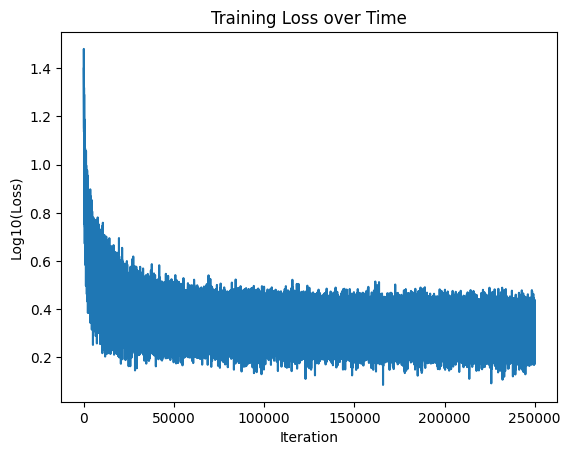

In [ ]:
plt.plot(stepi, lossi)                           # Plot loss values against iteration steps
plt.xlabel('Iteration')                          # Label for the x-axis
plt.ylabel('Log10(Loss)')                        # Label for the y-axis
plt.title('Training Loss over Time')             # Title of the plot
plt.show()                                       # Display the plot

In [ ]:
# Evaluate the model on the entire training set
# ----------------- Forward Pass -----------------
emb = C[Xtr]                                     # Get embeddings for the entire training set; shape: (N, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)       # Compute hidden layer activations; shape: (N, 200)
logits = h @ W2 + b2                             # Compute logits; shape: (N, 27)
# Compute cross-entropy loss on the training set
loss = F.cross_entropy(logits, Ytr)              # Compute loss over the entire training set
print(f"Training Loss: {loss.item()}")           # Print the training loss

Training Loss: 2.1085710525512695


In [ ]:
# Evaluate the model on the validation (development) set
# ----------------- Forward Pass -----------------
emb = C[Xdev]                                    # Get embeddings for the validation set; shape: (N_dev, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)       # Compute hidden layer activations; shape: (N_dev, 200)
logits = h @ W2 + b2                             # Compute logits; shape: (N_dev, 27)
# Compute cross-entropy loss on the validation set
loss = F.cross_entropy(logits, Ydev)             # Compute loss over the validation set
print(f"Validation Loss: {loss.item()}")         # Print the validation loss

Validation Loss: 2.1686205863952637


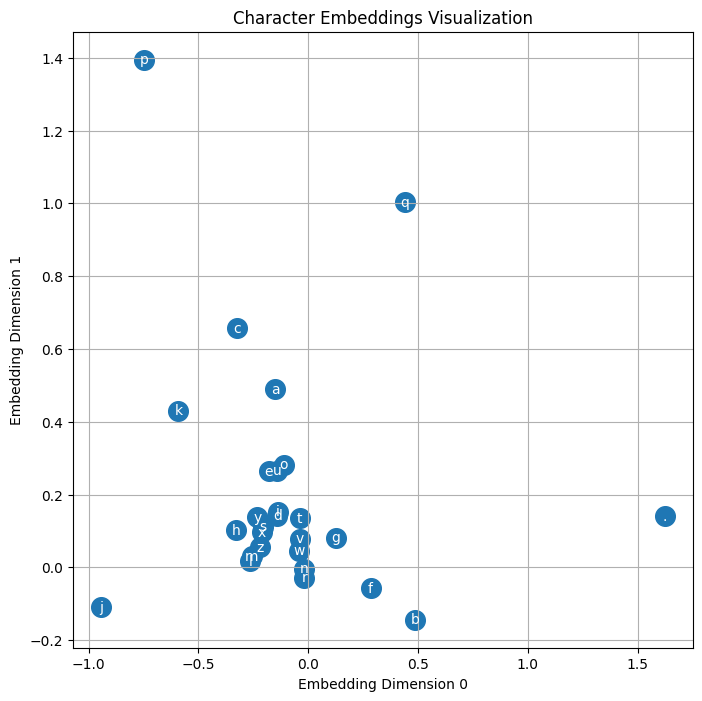

In [ ]:
# Visualize the first two dimensions of the character embeddings
plt.figure(figsize=(8, 8))                       # Set the figure size to 8x8 inches
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)   # Plot the embeddings for dimensions 0 and 1

# Annotate each point with the corresponding character
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i],  # Position of the text label
             ha="center", va="center", color='white')  # Center the text and set color to white

plt.grid('minor')                                # Add minor grid lines for better readability
plt.title('Character Embeddings Visualization')  # Title of the plot
plt.xlabel('Embedding Dimension 0')              # Label for x-axis
plt.ylabel('Embedding Dimension 1')              # Label for y-axis
plt.show()                                       # Display the plot

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [ ]:
# Example: Retrieve the embedding for a zero-initialized context
context = [0] * block_size                       # Create a context vector filled with zeros
embedding = C[torch.tensor([context])]           # Get the embedding for this context; shape: (1, block_size, embedding_dim)
print(f"Embedding shape: {embedding.shape}")     # Should output (1, 3, 10)
print(embedding)                                 # Print the embedding tensor

Embedding shape: torch.Size([1, 3, 10])
tensor([[[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,
           0.6049,  0.0791,  0.9046],
         [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,
           0.6049,  0.0791,  0.9046],
         [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,
           0.6049,  0.0791,  0.9046]]], grad_fn=<IndexBackward0>)


In [ ]:


# Sample new names from the trained model
g = torch.Generator().manual_seed(2147483647 + 10)  # Set a new seed for sampling

for _ in range(20):                                 # Generate 20 samples
    out = []                                        # List to store generated character indices
    context = [0] * block_size                      # Start with a context of all zeros

    while True:
        # ----------------- Forward Pass -----------------
        emb = C[torch.tensor([context])]            # Get embeddings for the current context; shape: (1, block_size, embedding_dim)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)   # Compute hidden layer activations; shape: (1, 200)
        logits = h @ W2 + b2                        # Compute logits; shape: (1, 27)
        probs = F.softmax(logits, dim=1)            # Apply softmax to get probabilities; shape: (1, 27)

        # ----------------- Sampling -----------------
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()  # Sample a character index based on probabilities

        # Update context and output
        context = context[1:] + [ix]                # Slide the context window and include the new character
        out.append(ix)                              # Append the sampled index to the output sequence

        if ix == 0:                                 # If the end-of-word token(.) is generated, stop sampling
            break

    # Convert the list of indices to characters and join them to form a word
    word = ''.join(itos[i] for i in out)
    print(word)                                     # Print the generated word

eria.
kayah.
seer.
ndhayla.
rethre.
eksrari.
adered.
eliighlynne.
leke.
susoraan.
kayzios.
kalin.
shubergihiries.
kendreth.
konn.
pacaulyn.
ged.
ryyah.
faeh.
ylah.
